In [1]:
# Import all libraries

import pandas as pd
import numpy as np
import glob
import os
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
rstate = 2
path = '../data_engineering/outputs/rental/'

In [3]:
# load the data
parquet_files = glob.glob(os.path.join(path, "*.parquet"))
data = pd.concat((pd.read_parquet(f) for f in parquet_files))

inputs = data[['sqfeet',
              'beds',
              'baths',
              'income',
              'density']]
              
outputs = data['price']

In [4]:
data.describe()

,sqfeet,beds,baths,income,density,price
count,364619.000000,364619.000000,364619.000000,364619.000000,364619.000000,364619.000000
mean,985.920421,1.887406,1.474538,52919.322411,2661.581543,1166.330460
std,370.303770,0.870946,0.581496,18833.256842,3957.104248,521.520512
min,0.000000,0.000000,0.000000,2499.000000,0.000000,100.000000
25%,750.000000,1.000000,1.000000,40412.000000,674.000000,810.000000
50%,945.000000,2.000000,1.000000,49942.000000,1739.000000,1033.000000
75%,1144.000000,2.000000,2.000000,63337.000000,3381.000000,1391.000000
max,5000.000000,8.000000,7.500000,250001.000000,141546.000000,4000.000000


In [5]:
import itertools
import matplotlib.pyplot as plt


def graph_dist(inputs):
    labels = ['sqfeet',
              'beds',
              'baths',
              'income',
              'density']
    
    fig,axs = plt.subplots(1,5,figsize=(25,5))
    for i in range(5):
        axs[i].scatter(inputs[labels[i]],inputs['price'])
        axs[i].set_xlabel(labels[i])
        axs[i].set_ylabel("Price")
    plt.tight_layout()
    return fig, axs


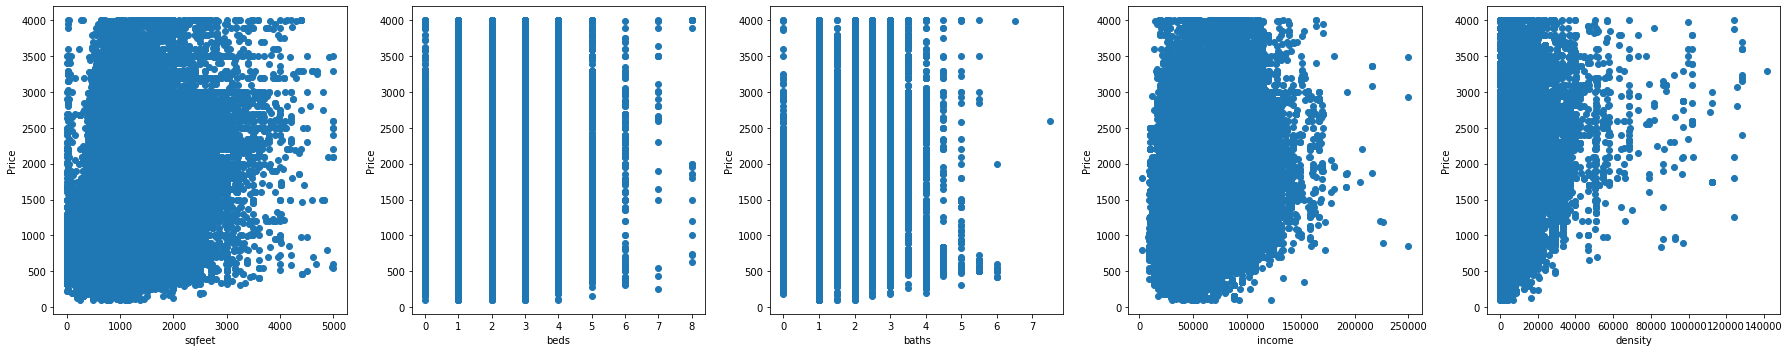

In [6]:
fig, axs = graph_dist(data)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size = 0.2, random_state=rstate)

### Trying Models, evaluating, and saving them

Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

linmodel = LinearRegression()
linmodel.fit(x_train, y_train)

LinearRegression()

In [9]:
linmodel.score(x_test, y_test)

0.36833333945084257

In [10]:
linmodel.predict(x_test)

array([ 965.41677583,  985.1848527 , 1069.05715965, ..., 1163.61663004,
       1276.94344334, 1220.34099866])

In [11]:
ridgemodel = Ridge()
ridgemodel.fit(x_train, y_train)

Ridge()

In [12]:
ridgemodel.score(x_test, y_test)

0.36833335228321984

In [13]:
ridgemodel.predict(x_test)

array([ 965.41561022,  985.18365769, 1069.05829943, ..., 1163.61674283,
       1276.94460978, 1220.34109848])

In [14]:
lassomodel = Lasso()
lassomodel.fit(x_train, y_train)

Lasso()

In [15]:
lassomodel.score(x_test, y_test)

0.36833129664910524

In [16]:
lassomodel.predict(x_test)

array([ 962.06908345,  980.49801265, 1073.16030816, ..., 1164.62360843,
       1281.88716035, 1219.97824146])

In [17]:
import eli5
eli5.show_weights(lassomodel, feature_names = inputs.columns.tolist())

Weight?,Feature
+97.755,baths
+0.499,sqfeet
+0.045,density
+0.010,income
-30.388,<BIAS>
-49.276,beds


In [18]:
pickle.dump(linmodel, open('./outputs/rent_models/linmodel.pkl', 'wb'))
pickle.dump(ridgemodel, open('./outputs/rent_models/ridgemodel.pkl', 'wb'))
pickle.dump(lassomodel, open('./outputs/rent_models/lassomodel.pkl', 'wb'))

Decision Tree

In [19]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(random_state=rstate)
dtree.fit(x_train, y_train)

DecisionTreeRegressor(random_state=2)

In [20]:
dtree.score(x_test, y_test)

0.7160061418249076

In [21]:
dtree.predict(x_test)

array([ 972.91666667,  615.        ,  960.        , ..., 1650.        ,
       1060.        , 1092.5       ])

In [22]:
# Tuning dtree parameters
dtree_search = GridSearchCV(dtree, param_grid={
        'max_depth':np.arange(10, 100, 10),
        }, cv=2)
dtree_search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % dtree_search.best_score_)
print(dtree_search.best_params_)

Best parameter (CV score=0.638):
{'max_depth': 40}


In [23]:
pickle.dump(dtree, open('./outputs/rent_models/decision_tree.pkl', 'wb'))
pickle.dump(dtree_search, open('./outputs/rent_models/decision_tree_gridsearch.pkl', 'wb'))

Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

randforest = RandomForestRegressor(random_state=rstate)
randforest.fit(x_train, y_train)

RandomForestRegressor(random_state=2)

In [25]:
randforest.score(x_test, y_test)

0.8296607935362627

In [26]:
randforest.predict(x_test)

array([ 973.04182722,  615.        ,  960.        , ..., 1643.24444444,
       1133.78666667, 1089.05820166])

In [64]:
randforest_search = GridSearchCV(randforest, param_grid={
        'n_estimators':np.arange(100,300,50),
        'max_depth': np.arange(50,200,50)
        }, cv=2)
randforest_search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % randforest_search.best_score_)
print(randforest_search.best_params_)

Best parameter (CV score=0.791):
{'max_depth': 100, 'n_estimators': 250}


In [65]:
randforest_search.score(x_test, y_test)

0.8309417785598416

In [66]:
randforest_search.predict(x_test)

array([ 972.92116883,  615.        ,  960.        , ..., 1635.69295238,
       1143.33366667, 1091.45850827])

In [68]:
randforest = RandomForestRegressor(random_state=rstate, n_estimators=250, max_depth=100)
randforest.fit(x_train, y_train)

RandomForestRegressor(max_depth=100, n_estimators=250, random_state=2)

In [69]:
randforest.score(x_test, y_test)

0.8309417785598416

In [70]:
randforest.predict(x_test)

array([ 972.92116883,  615.        ,  960.        , ..., 1635.69295238,
       1143.33366667, 1091.45850827])

In [67]:
pickle.dump(randforest, open('./outputs/rent_models/random_forest.pkl', 'wb'))
pickle.dump(randforest_search, open('./outputs/rent_models/randforest_search.pkl', 'wb'))

XGBoost

In [28]:
from xgboost import XGBRegressor

xgb = XGBRegressor(seed=rstate)
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=2, ...)

In [29]:
xgb.score(x_test, y_test)

0.6737568380813758

In [30]:
xgb.predict(x_test)

array([ 980.2117,  620.0603,  939.1987, ..., 1334.2593, 1157.4539,
       1132.0017], dtype=float32)

In [31]:
xgb_search = GridSearchCV(xgb, param_grid={
        'n_estimators':np.arange(100,300,50),
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
        }, cv=2)
xgb_search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % xgb_search.best_score_)
print(xgb_search.best_params_)

Best parameter (CV score=0.737):
{'learning_rate': 0.3, 'n_estimators': 250}


In [32]:
xgb_search.predict(x_test)

array([ 912.76105,  598.14453,  936.151  , ..., 1374.7236 , 1094.6902 ,
       1125.4263 ], dtype=float32)

In [33]:
xgb = XGBRegressor(seed=rstate, learning_rate=0.3, n_estimators=250)
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=250, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=2, ...)

In [34]:
xgb.score(x_test, y_test)

0.7564288408196409

In [35]:
pickle.dump(xgb, open('./outputs/rent_models/xgb.pkl', 'wb'))
pickle.dump(xgb_search, open('./outputs/rent_models/xgb_gridsearch.pkl', 'wb'))

CatBoost

In [36]:
from catboost import CatBoostRegressor

catboost = CatBoostRegressor(random_seed=rstate, verbose=False)
catboost.fit(x_train, y_train)

In [37]:
catboost.score(x_test, y_test)

0.6404537939082628

In [38]:
catboost.predict(x_test)

array([1004.81983364,  624.18623837,  995.94316282, ..., 1373.50087711,
       1210.17777764, 1092.60806154])

In [39]:
catboost_search = GridSearchCV(catboost, param_grid={
        'n_estimators':np.arange(100,300,50),
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
        }, cv=2)
catboost_search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % catboost_search.best_score_)
print(catboost_search.best_params_)

Best parameter (CV score=0.606):
{'learning_rate': 0.3, 'n_estimators': 250}


In [40]:
catboost_search.predict(x_test)

array([1092.25396353,  657.39388983, 1008.68228316, ..., 1377.04732931,
       1276.54195026, 1157.55620584])

In [41]:
pickle.dump(catboost, open('./outputs/rent_models/catboost.pkl', 'wb'))
pickle.dump(catboost_search, open('./outputs/rent_models/catboost_gridsearch.pkl', 'wb'))

K-Nearest-Neighbors

In [8]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(x_train, y_train)

KNeighborsRegressor()

In [9]:
knn.score(x_test, y_test)

0.78774356067088

In [10]:
x_test.iloc[0]

sqfeet       906.0
beds           2.0
baths          2.0
income     33496.0
density     2351.0
Name: 84586, dtype: float64

In [11]:
knn.predict([x_test.iloc[0]])

/Users/nathanyee/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


array([975.])

In [12]:
y_test.iloc[0]

975.0

In [13]:
knn.predict(x_test)

array([ 975.,  615.,  960., ..., 1514., 1060., 1082.])

In [48]:
knn_search = GridSearchCV(knn, param_grid={
        'n_neighbors':np.arange(1, 50),
        }, cv=2)
knn_search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % knn_search.best_score_)
print(knn_search.best_params_)

Best parameter (CV score=0.747):
{'n_neighbors': 3}


In [14]:
pickle.dump(knn, open('./outputs/rent_models/knn.pkl', 'wb'))
pickle.dump(knn_search, open('./outputs/rent_models/knn_gridsearch.pkl', 'wb'))

Tensorflow Neural Network

In [50]:
# Keras NN model to be created
def create_model(inputs, outputs):
    input_layer = Input(shape=(5, ))
    x1 = Dense(15, activation='relu', kernel_initializer='normal') (input_layer)
    x2 = Dense(5, activation='relu', kernel_initializer='normal') (x1)
    x3 = Dense(3, activation='relu', kernel_initializer='normal') (x2)
    output = Dense(1, activation='linear', kernel_initializer='normal') (x3)

    t_model = Model(inputs=input_layer, outputs=output)

    t_model.compile(
        loss='mean_squared_error', 
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["mean_squared_error"]
    )
    
    t_model.fit(inputs, outputs, epochs=350, batch_size=1000, verbose=True)
    return t_model

In [51]:
nn_model = create_model(x_train, y_train)

2022-11-26 15:12:35.724583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/350
292/292 [==============================] - 1s 1ms/step - loss: 512984.9375 - mean_squared_error: 512984.9375
Epoch 2/350
292/292 [==============================] - 0s 1ms/step - loss: 218568.8594 - mean_squared_error: 218568.8594
Epoch 3/350
292/292 [==============================] - 0s 1ms/step - loss: 198501.7188 - mean_squared_error: 198501.7188
Epoch 4/350
292/292 [==============================] - 0s 1ms/step - loss: 172951.1094 - mean_squared_error: 172951.1094
Epoch 5/350
292/292 [==============================] - 0s 1ms/step - loss: 168208.7344 - mean_squared_error: 168208.7344
Epoch 6/350
292/292 [==============================] - 0s 1ms/step - loss: 167981.4531 - mean_squared_error: 167981.4531
Epoch 7/350
292/292 [==============================] - 1s 2ms/step - loss: 167892.9062 - mean_squared_error: 167892.9062
Epoch 8/350
292/292 [==============================] - 1s 2ms/step - loss: 167857.2969 - mean_squared_error: 167857.2969
Epoch 9/350
292/292 [===========

In [52]:
x_test.iloc[0]

sqfeet       906.0
beds           2.0
baths          2.0
income     33496.0
density     2351.0
Name: 84586, dtype: float64

In [53]:
y_test.to_numpy()

array([ 975.,  615.,  960., ..., 1650.,  940.,  985.])

In [54]:
y_pred = nn_model.predict(x_test)
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.39553779611301243

In [55]:
nn_model.evaluate(x_test, y_test)

2279/2279 [==============================] - 2s 992us/step - loss: 165308.9062 - mean_squared_error: 165308.9062


[165308.90625, 165308.90625]

In [56]:
nn_model.save('./outputs/rent_models/nn_model.h5')

In [57]:
# Tune the model
import keras_tuner
from kerastuner.tuners import RandomSearch, Hyperband

/var/folders/4p/0tpbwp7d5fj91r2jb64xf4kh0000gn/T/ipykernel_19600/3089064041.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, Hyperband


In [58]:
def build_model(hp):
    input_layer = Input(shape=(5, ))
    x1 = Dense(hp.Choice('firstlayer', [16,24,32]), activation=hp.Choice("x1_activation", ['relu', 'sigmoid', 'tanh']), kernel_initializer='normal')(input_layer)
    x2 = Dense(hp.Choice('secondlayer', [4,5,8,16]), activation=hp.Choice("x2_activation", ['relu', 'sigmoid', 'tanh']), kernel_initializer='normal')(x1)
    x3 = Dense(hp.Choice('thirdlayer', [3,4,5,6,7,8]), activation=hp.Choice("x3_activation", ['relu', 'sigmoid', 'tanh']), kernel_initializer='normal')(x2)
    output = Dense(1, activation='linear', kernel_initializer='normal')(x3)

    t_model = Model(inputs=input_layer, outputs=output)

    t_model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])),
        metrics=["mean_squared_error"]
    )
    return t_model


In [60]:
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs= 20
)
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Trial 38 Complete [00h 00m 40s]
val_loss: 274218.3125

Best val_loss So Far: 168970.234375
Total elapsed time: 00h 29m 19s

Search: Running Trial #39

Value             |Best Value So Far |Hyperparameter
24                |24                |firstlayer
relu              |relu              |x1_activation
16                |5                 |secondlayer
sigmoid           |relu              |x2_activation
7                 |6                 |thirdlayer
tanh              |relu              |x3_activation
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
4403/9116 [=============>................] - ETA: 10s - loss: 1580507.8750 - mean_squared_error: 1580507.8750

KeyboardInterrupt: 

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
firstlayer (Choice)
{'default': 16, 'conditions': [], 'values': [16, 24, 32], 'ordered': True}
x1_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
secondlayer (Choice)
{'default': 4, 'conditions': [], 'values': [4, 5, 8, 16], 'ordered': True}
x2_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
thirdlayer (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4, 5, 6, 7, 8], 'ordered': True}
x3_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
firstlayer: 16
x1_activation: relu
secondlayer: 4
x2_activation: tanh
thirdlayer: 8
x3_activation: relu
learning_rate: 0.001
Score: 336496.28125
Trial summary
Hyperparameters:
firstlayer: 24
x1_activation: tanh
secondlayer: 8
x2_activation: relu
thirdlayer: 8
x3_activation: sigmoid
learning_rate: 0.01
Score: 336496.375
Trial summary
Hyperparameters:
firstlayer: 16
x1_activation: sigmoid
secondlayer: 8
x2_activation: relu
thirdlayer: 3
x3_activation: tanh
learning_rate: 0.1
Score: 336496.5
Trial summary
Hyperparameters:
firstlayer: 24
x1_activation: tanh
secondlayer: 16
x2_activation: tanh
thirdlayer: 4
x3_activation: tanh
learning_rate: 0.01
Score: 336496.53125
Trial summary
Hyperparameters:
firstlayer: 32
x1_activation: tanh
secondlayer: 16
x2_activation: tanh
thirdlayer: 6
x3_activation: relu
learning_rate: 0.01
Score: 336498.84375
Trial summary
Hyperparameters:
firstlayer: 16
x1_activ

In [61]:
# Keras NN model to be created
def create_model(inputs, outputs):
    input_layer = Input(shape=(5, ))
    x1 = Dense(24, activation='relu', kernel_initializer='normal') (input_layer)
    x2 = Dense(5, activation='relu', kernel_initializer='normal') (x1)
    x3 = Dense(6, activation='relu', kernel_initializer='normal') (x2)
    output = Dense(1, activation='linear', kernel_initializer='normal') (x3)

    t_model = Model(inputs=input_layer, outputs=output)

    t_model.compile(
        loss='mean_squared_error', 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["mean_squared_error"]
    )
    
    t_model.fit(inputs, outputs, epochs=350, batch_size=1000, verbose=True)
    return t_model

In [62]:
nn_model = create_model(x_train, y_train)

Epoch 1/350
292/292 [==============================] - 1s 2ms/step - loss: 523925.5000 - mean_squared_error: 523925.5000
Epoch 2/350
292/292 [==============================] - 0s 1ms/step - loss: 218623.5781 - mean_squared_error: 218623.5781
Epoch 3/350
292/292 [==============================] - 0s 2ms/step - loss: 204920.5000 - mean_squared_error: 204920.5000
Epoch 4/350
292/292 [==============================] - 0s 1ms/step - loss: 184126.2188 - mean_squared_error: 184126.2188
Epoch 5/350
292/292 [==============================] - 0s 1ms/step - loss: 173326.5938 - mean_squared_error: 173326.5938
Epoch 6/350
292/292 [==============================] - 0s 1ms/step - loss: 172951.9531 - mean_squared_error: 172951.9531
Epoch 7/350
292/292 [==============================] - 1s 2ms/step - loss: 172988.1094 - mean_squared_error: 172988.1094
Epoch 8/350
292/292 [==============================] - 0s 2ms/step - loss: 172993.0469 - mean_squared_error: 172993.0469
Epoch 9/350
292/292 [===========

In [63]:
y_pred = nn_model.predict(x_test)
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.39406318512882654

In [71]:
nn_model.save('./outputs/rent_models/nn_model_v2.h5')